In [57]:
import os
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import f1_score, accuracy_score
from IPython.display import clear_output

# Implicit hate speech detection

Get help from this [kaggle page](https://www.kaggle.com/code/yousefadham/working-hatebert)

# Load the data

In [2]:
PATH_DATA = "data/implicit-hate-corpus/"

PATH_DATA_STG1 = PATH_DATA + "/implicit_hate_v1_stg1_posts.tsv"
PATH_DATA_STG2 = PATH_DATA + "implicit_hate_v1_stg2_posts.tsv"

data = pd.read_csv(PATH_DATA_STG1, sep = '\t')
print(data)

                                                    post          class
0        " : jewish harvard professor noel ignatiev w...  implicit_hate
1       b.higher education is a part of european cult...       not_hate
2       has a problem with  " the whites " " and " " ...       not_hate
3       is yasir qadhi a hate preacher for calling ch...       not_hate
4       rt  " : how three million germans mass murder...       not_hate
...                                                  ...            ...
21475  Seeing prostitutes is morally wrong, but being...  implicit_hate
21476  I wonder how many females I raped today I spen...  implicit_hate
21477  Having a criminal record is more attractive to...  implicit_hate
21478  Another advantage of being a female: getting b...  implicit_hate
21479  If men are so privileged and women have it so ...  implicit_hate

[21480 rows x 2 columns]


# Data Set  Distribution 

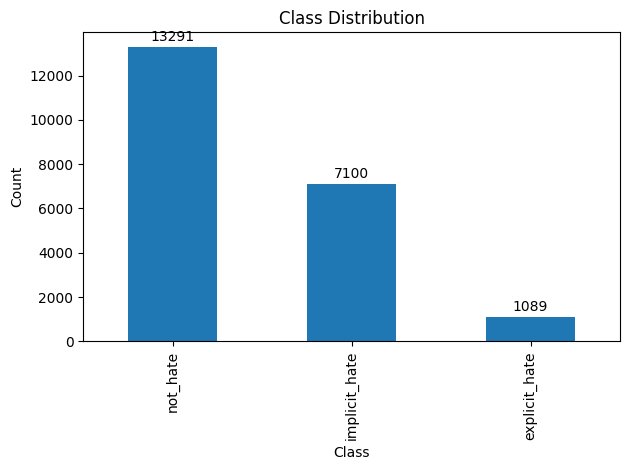

In [3]:
class_counts = data['class'].value_counts()

# Plot
ax = class_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

for i, count in enumerate(class_counts):
    plt.text(i, count + max(class_counts)*0.01, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# General Constant

In [4]:
#Set some general constant that will be used in the entire code
RANDOM_SEED = 42
NUM_LABELS = 3
MAX_LENGTH = 512 #max size of the tokenizer https://huggingface.co/GroNLP/hateBERT/commit/f56d507e4b6a64413aff29e541e1b2178ee79d67
EPOCHS = 4
BATCH_SIZE = 1

## Data preparation (labels and text extraction and remaping)

As we don't necessary have the computational power to train the model for the 21480 posts data, we will select only the 20 first posts for the training

In [5]:
data = data.head(20)
data

,post,class
0,""" : jewish harvard professor noel ignatiev w...",implicit_hate
1,b.higher education is a part of european cult...,not_hate
2,"has a problem with "" the whites "" "" and "" "" ...",not_hate
3,is yasir qadhi a hate preacher for calling ch...,not_hate
4,"rt "" : how three million germans mass murder...",not_hate
5,"rt "" we were murdered graffiti in synagogues...",not_hate
6,rt : tune in today's jmt for my interview w /...,implicit_hate
7,rt black supremacist arrested for threatening...,not_hate
8,rt crooked hillary you didn't lose because yo...,explicit_hate
9,"rt estonian pm : "" i don't want blacks in es...",explicit_hate


In [6]:
# Label mappings
id2label = {0: "not_hate", 1: "implicit_hate", 2: "explicit_hate"}
label2id = {"not_hate": 0, "implicit_hate": 1, "explicit_hate": 2}


# Load data text
texts = data['post'].values

# Convert the labels to numerical values
print("Labels before mapping: \n", data['class'].values[:11])
data['class'] = data['class'].map(label2id)
labels = data['class'].values
print("Labels after mapping:  ", labels[:11])

Labels before mapping: 
 ['implicit_hate' 'not_hate' 'not_hate' 'not_hate' 'not_hate' 'not_hate'
 'implicit_hate' 'not_hate' 'explicit_hate' 'explicit_hate' 'not_hate']
Labels after mapping:   [1 0 0 0 0 0 1 0 2 2 0]


# Load the Hate Bert model

We decide to use the Hate Bert model, a Bert model specially trained to detect hate. This model can be use from hugging face [plateforme](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html).

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(
    "GroNLP/hateBERT",
    num_labels=NUM_LABELS,
    id2label=id2label, 
    label2id=label2id,
)

print(model.num_parameters())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


109484547


### Load the tokenizer

From hugging face plateforme, we can also load the tokenizer specially made for Hate Bert

In [8]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")

### DataLoader initialization & Data splitting

In [9]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return  {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }
    
        
           

In [10]:
# Spliting data (80% train and 20% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=RANDOM_SEED
)

# TRAIN dataset
train_dataset = HateSpeechDataset(
    texts=train_texts,
    labels=train_labels,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

# TESTING dataset
test_dataset = HateSpeechDataset(
    texts=test_texts,
    labels=test_labels,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)


# DATALOADER for training set
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# DATALOADER for testing set
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## Train the model

We use the default training configuration from the kaggle page

In [47]:
def train_epoch(model, optimizer, criterion, metrics, train_dataloader, device):
    
    #progress_bar = tqdm(range(num_training_steps))
    # put the model in train mode
    model.train()

    # initialize epoch loss and metrics
    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    # iterate over batches in training set
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        target = batch["labels"]  # Get the target labels
        # forward pass, get the outputs from the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=target)
        # get the loss from the outputs
        loss = outputs.loss

        # do the backward pass
        loss.backward()

        # perform one step of the optimizer
        optimizer.step()

        # peform one step of the lr_scheduler, similar with the optimizer
        lr_scheduler.step()
       
        # zero the gradients, call zero_grad() on the optimizer
        optimizer.zero_grad()
        #Facilitate the update of the bar by creating artifical waiting time
        #time.sleep(0.01)

        #progress_bar.update(1)

        with torch.no_grad():
           preds = torch.argmax(outputs.logits, dim=1)

   
        with torch.no_grad():
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds.cpu(), target.cpu())

        # log loss statistics
        epoch_loss += loss.item()

    # for the epoch loss, we take the average of the losses computed over the mini-batches
    epoch_loss /= len(train_dataloader)

    # for the epoch loss, we compute the average of the metrics over the mini-batches
    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(train_dataloader)

    clear_output() #clean the prints from previous epochs
    print('train Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

## Testing

In [55]:
# Initialize lists to store predictions and true labels
all_predictions = []
all_labels = []

def evaluate(model, criterion, metrics, test_dataloader, device):
    
    # put the model in eval mode
    model.eval()
    
    #progress_bar = tqdm(range(len(test_dataloader)))

    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    
    # iterate over batches of evaluation dataset
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            # forward pass, get the outputs from the model
            outputs = model(**batch)
    
        #get the logits from the outputs
        logits = outputs.logits
    
        # use argmax to get the predicted class
        preds = torch.argmax(logits, dim=-1)
        
        # Append predictions and true labels to the lists
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

        for k in epoch_metrics.keys():
            epoch_metrics[k] += metrics[k](preds.cpu(), target.cpu())

            epoch_loss += loss.item()
    
        #progress_bar.update(1)
    epoch_loss /= len(test_dataloader)
    
    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(test_dataloader)

    print('eval Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))
    return epoch_loss,  epoch_metrics

In [16]:
def plot_training(train_loss, test_loss, metrics_names, train_metrics_logs, test_metrics_logs):
    fig, ax = plt.subplots(1, len(metrics_names) + 1, figsize=((len(metrics_names) + 1) * 5, 5))

    ax[0].plot(train_loss, c='blue', label='train')
    ax[0].plot(test_loss, c='orange', label='test')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    for i in range(len(metrics_names)):
        ax[i + 1].plot(train_metrics_logs[i], c='blue', label='train')
        ax[i + 1].plot(test_metrics_logs[i], c='orange', label='test')
        ax[i + 1].set_title(metrics_names[i])
        ax[i + 1].set_xlabel('epoch')
        ax[i + 1].legend()

    plt.show()

def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    '''
    - metrics_names: the keys/names of the logged metrics
    - metrics_log: existing metrics log that will be updated
    - new_metrics_dict: epoch_metrics output from train_epoch and evaluate functions
    '''
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log

In [17]:
def train_cycle(model, optimizer, criterion, metrics, train_loader, test_loader, n_epochs, device):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_loader, device)

        test_loss, test_metrics = evaluate(model, criterion, metrics, test_loader, device)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)
    return train_metrics_log, test_metrics_log


Training cycle

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [21]:
optimizer = AdamW(model.parameters(), lr=2e-5)

# Class distribution from your dataset
class_counts = [13291, 7100, 1089]
total = sum(class_counts)

# Inverse frequency (optional: normalize)
class_weights = [total / c for c in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Use weighted BCEWithLogitsLoss
criterion = BCEWithLogitsLoss(weight=class_weights)

num_training_steps = EPOCHS * len(train_dataloader)
# feel free to experiment with different num_warmup_steps
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=1, num_training_steps=num_training_steps
)


In [23]:
def f1(preds, target):
    return f1_score(target, preds, average='macro')

def acc(preds, target):
    return accuracy_score(target, preds)

train Loss: 0.5148,  ACC: 0.8125, F1-weighted: 0.8125
eval Loss: 0.5508,  ACC: 1.0000, F1-weighted: 1.0000


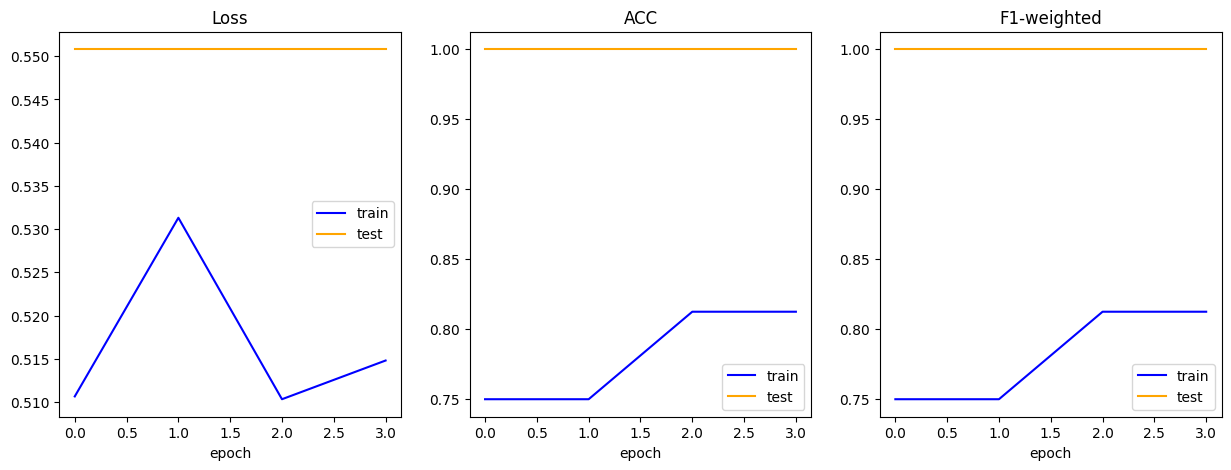

In [58]:
metrics = {'ACC': acc, 'F1-weighted': f1}

model.to(device)
criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_dataloader, test_dataloader, n_epochs=EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model.pth')